In [106]:
# import modules and packages

import pandas as pd
from datetime import datetime, date, time, timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sms
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import geopandas as gpd
import  as gplt
%matplotlib inline

ModuleNotFoundError: No module named 'geoplot'

In [2]:
# add some styles for plotting
# sns.set_context("talk", font_scale=1.0) #this will be applied to all subsequent executed plots

In [3]:
# load the data and have first look
df = pd.read_csv('../data/King_County_House_prices_dataset.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# Column Names and descriptions for King County Data Set
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  # of bedrooms
* **bathroomsNumber** - # of bathrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

# My stakeholder is Thomas Hansen
## Thomas Hansen	Buyer	5 kids, no money, wants nice (social) neighbourhood, Timing?, Location?

### Assumptions:

--> no money, means he can't afford more than 300.000 USD

--> area is relevant, means he would love to live in the city center of Seattle or in a high density linving area (sqft_living15)

--> 5 kids, means # rooms is relevant: he needs min. 5 rooms

--> size is relevant, means he needs min. 1500 sqft

--> maybe timing is relevant? can he maybe wait a couple of months, if houses are cheaper in winter?

--> people do not like to move/renovate in winter, families tend to move in summer due to school start in autumn

--> in areas with high density there are more restaurants, more shops, more bars, i.e. they are nicer

--> people in general prefer to live in areas with big houses and lots, which have a garden. So areas, where the sqft of your neighbours are in general smaller, should be cheaper

--> not many new or renovated or big houses in high density area, houses prices in general are probably cheaper



### maybe not that important for Thomas:

--> yr_built

--> yr_renovated

--> condition

--> grade

### General information
coordinates of central Seattle: 47.608013, -122.335167
--> radius of 15 miles around Seattle


[Seattle City Center Zip Codes](
https://www.usmapguide.com/washington/seattle-zip-code-map/ "Seattle City Center Zip Codes")


[General Information about Seattle](
https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r/ "General Information about Seattle")


### Hypotheses 1: There is no such house available in Thomas preferred neighbourhood. 

### Hypotheses 2: houses are cheaper in winter

### Hypotheses 3: areas with high density might have cheaper houses


In [4]:
# get some general information about the dataframe (amount, date type)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

### The dataframe has 21.597 entries and 20 columns 

1. Missing values for waterfront
2. Missing values for view
3. Missing values for yr_renovated
4. id is probably not relevant

--> might be good to drop these columns

5. date is type object --> change to datetime
6. sqft_basement type object --> maybe need to change it to float/int

# 2. Data Wrangling

Comments:
- sqft living vs. sqft lot - should be the size of the property
- waterfront not relevant for Thomas 
- view is not totally clear, better get rid of it
- sgft_living15/sqft_lot15 - what does it say about the neighbourhood?

In [5]:
# check for missing values in the dataframe
df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [6]:
# drop columns id, waterfront, view and yr_renovated to optimize the dataframe
df.drop(['id', 'waterfront', 'view', 'yr_renovated'], axis=1, inplace=True)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0.0,1955,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,3,7,2170,400.0,1951,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,3,6,770,0.0,1933,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,5,7,1050,910.0,1965,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,3,8,1680,0.0,1987,98074,47.6168,-122.045,1800,7503


In [7]:
# check for duplicates
sum(df.duplicated())

0

In [8]:
# change datatype of 'date' to datetime
df.date = pd.to_datetime(df.date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  float64       
 2   bedrooms       21597 non-null  int64         
 3   bathrooms      21597 non-null  float64       
 4   sqft_living    21597 non-null  int64         
 5   sqft_lot       21597 non-null  int64         
 6   floors         21597 non-null  float64       
 7   condition      21597 non-null  int64         
 8   grade          21597 non-null  int64         
 9   sqft_above     21597 non-null  int64         
 10  sqft_basement  21597 non-null  object        
 11  yr_built       21597 non-null  int64         
 12  zipcode        21597 non-null  int64         
 13  lat            21597 non-null  float64       
 14  long           21597 non-null  float64       
 15  sqft_living15  2159

In [9]:
# combine coordinates lat and lon to "lat/lon"
df['lat/long'] = df[['lat', 'long']].astype(str).apply(', '.join, 1)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,lat/long
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0.0,1955,98178,47.5112,-122.257,1340,5650,"47.5112, -122.257"
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,3,7,2170,400.0,1951,98125,47.7210,-122.319,1690,7639,"47.721, -122.319"
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,3,6,770,0.0,1933,98028,47.7379,-122.233,2720,8062,"47.7379, -122.233"
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,5,7,1050,910.0,1965,98136,47.5208,-122.393,1360,5000,"47.5208, -122.393"
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,3,8,1680,0.0,1987,98074,47.6168,-122.045,1800,7503,"47.6168, -122.045"


In [10]:
# add month and year as a separate columns
df['month'] = df.date.dt.month
df['year'] = df.date.dt.year
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,lat/long,month,year
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0.0,1955,98178,47.5112,-122.257,1340,5650,"47.5112, -122.257",10,2014
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,3,7,2170,400.0,1951,98125,47.7210,-122.319,1690,7639,"47.721, -122.319",12,2014
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,3,6,770,0.0,1933,98028,47.7379,-122.233,2720,8062,"47.7379, -122.233",2,2015
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,5,7,1050,910.0,1965,98136,47.5208,-122.393,1360,5000,"47.5208, -122.393",12,2014
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,3,8,1680,0.0,1987,98074,47.6168,-122.045,1800,7503,"47.6168, -122.045",2,2015


# 3. Exploratory Data Analysis

In [11]:
# get a statistical summary of the dataframe
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,month,year
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,3.409825,7.657915,1788.596842,1970.999676,98077.951845,47.560093,-122.213982,1986.620318,12758.283512,6.573969,2014.322962
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.650546,1.173200,827.759761,29.375234,53.513072,0.138552,0.140724,685.230472,27274.441950,3.115061,0.467619
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1.000000,3.000000,370.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000,1.000000,2014.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,3.000000,7.000000,1190.000000,1951.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000,4.000000,2014.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,3.000000,7.000000,1560.000000,1975.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000,6.000000,2014.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,4.000000,8.000000,2210.000000,1997.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000,9.000000,2015.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,5.000000,13.000000,9410.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,12.000000,2015.000000


In [12]:
# check number of unique values for each column
df.nunique()

date               372
price             3622
bedrooms            12
bathrooms           29
sqft_living       1034
sqft_lot          9776
floors               6
condition            5
grade               11
sqft_above         942
sqft_basement      304
yr_built           116
zipcode             70
lat               5033
long               751
sqft_living15      777
sqft_lot15        8682
lat/long         20818
month               12
year                 2
dtype: int64

In [13]:
# count values for bedrooms
# Thomas needs min. 5 bedrooms
df.bedrooms.value_counts().sort_index()

1      196
2     2760
3     9824
4     6882
5     1601
6      272
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

Over 1.900 houses with at least 5 bedrooms

In [14]:
# price range for houses
# Thomas can only afford 300.000 USD
df.price.quantile([0.1, 0.25, 0.5, 0.75, 0.99])

0.10     245000.0
0.25     322000.0
0.50     450000.0
0.75     645000.0
0.99    1970000.0
Name: price, dtype: float64

Only around 25 % of the houses are affordable for Thomas 

In [15]:
# check size of houses
# Thomas needs min. 1500 sqft
df.sqft_living.describe()

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

Over 50 % of the houses are big enough for Thomas' family.

In [16]:
# check for houses with min. 5 bedrooms and max 1500 sqft under 300.000 USD

df_possible_houses = df.query('bedrooms >= 5 and sqft_living >= 1500 and price <= 300000')
df_possible_houses

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,lat/long,month,year
22,2014-07-03,285000.0,5,2.50,2270,6300,2.0,3,8,2270,0.0,1995,98092,47.3266,-122.169,2240,7005,"47.3266, -122.169",7,2014
148,2014-10-30,258000.0,5,2.00,2260,12500,1.0,4,8,1130,1130.0,1960,98032,47.3887,-122.286,1360,18000,"47.3887, -122.286",10,2014
160,2014-05-07,255000.0,5,2.25,2060,8632,1.0,3,7,1030,1030.0,1962,98146,47.4877,-122.335,1010,11680,"47.4877, -122.335",5,2014
311,2014-10-23,201000.0,5,1.75,1660,78408,1.5,3,6,1660,0.0,1915,98065,47.5290,-121.837,1660,78408,"47.529, -121.837",10,2014
331,2015-04-16,279000.0,6,1.75,2240,11180,2.0,4,7,2240,0.0,1955,98198,47.4200,-122.323,1590,7955,"47.42, -122.323",4,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20377,2014-09-17,300000.0,6,3.00,2744,9926,2.0,3,7,2744,0.0,2006,98002,47.2773,-122.216,2470,9926,"47.2773, -122.216",9,2014
20536,2014-05-19,298450.0,5,3.00,2100,9752,1.0,3,8,1200,900.0,2007,98003,47.3341,-122.304,1270,10200,"47.3341, -122.304",5,2014
20636,2014-05-22,300000.0,5,2.50,2760,6000,2.0,3,8,2760,0.0,2006,98108,47.5289,-122.321,1360,6000,"47.5289, -122.321",5,2014
20743,2014-06-25,260000.0,5,2.50,2025,7760,2.0,3,7,2025,0.0,2007,98001,47.2671,-122.256,1664,9000,"47.2671, -122.256",6,2014


### From the originally 21.597 houses only 132 match Thomas criteria regarding bedrooms and size. 
Let's see how many are situated in a nice area. We assume that the city center of Seattle is a nice social area, where Thomas and his family would like to live.

In [17]:
# create a list of zip codes of Seattle
zip_codes = [98177, 98133, 98155, 98125, 98117, 98103, 98115, 98107, 98105, 98199, 98109, 98102, 98112, 98121, 98101, 98154, 98104, 98122, 98144, 98134, 98116, 98136, 98126, 98106, 98108, 98118, 98146, 98168, 98178]

# sort the list and check for duplicates
zip_codes.sort()
zip_codes

[98101,
 98102,
 98103,
 98104,
 98105,
 98106,
 98107,
 98108,
 98109,
 98112,
 98115,
 98116,
 98117,
 98118,
 98121,
 98122,
 98125,
 98126,
 98133,
 98134,
 98136,
 98144,
 98146,
 98154,
 98155,
 98168,
 98177,
 98178,
 98199]

In [18]:
# check if a house is situated in one of the zip codes of Seattle
df_check_zipcode = df_possible_houses['zipcode'].apply(lambda x:1 if x in zip_codes else 0)

# join the two dataframes
df_possible_houses_in_Seattle = pd.concat([df_possible_houses, df_check_zipcode], axis=1)

# filter for zipcode = 1, meaning is located in Seattle and show results
df_results = df_possible_houses_in_Seattle.query('zipcode == 1')
df_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 160 to 20636
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           34 non-null     datetime64[ns]
 1   price          34 non-null     float64       
 2   bedrooms       34 non-null     int64         
 3   bathrooms      34 non-null     float64       
 4   sqft_living    34 non-null     int64         
 5   sqft_lot       34 non-null     int64         
 6   floors         34 non-null     float64       
 7   condition      34 non-null     int64         
 8   grade          34 non-null     int64         
 9   sqft_above     34 non-null     int64         
 10  sqft_basement  34 non-null     object        
 11  yr_built       34 non-null     int64         
 12  zipcode        34 non-null     int64         
 13  lat            34 non-null     float64       
 14  long           34 non-null     float64       
 15  sqft_living15  34 no

In [19]:
# show the results
df_results.sort_values(by= ['price'])

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,...,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,lat/long,month,year,zipcode
3536,2014-06-10,175000.0,6,1.50,1930,8400,1.0,3,7,1030,...,1971,98146,47.4869,-122.340,1780,9520,"47.4869, -122.34",6,2014,1
3197,2015-02-24,178000.0,5,1.50,1990,18200,1.0,3,7,1990,...,1960,98178,47.4938,-122.262,1860,8658,"47.4938, -122.262",2,2015,1
7533,2015-03-12,183750.0,5,2.75,1650,5453,1.0,3,7,1650,...,1970,98118,47.5293,-122.285,1670,5885,"47.5293, -122.285",3,2015,1
10397,2014-07-02,185000.0,5,1.00,1590,6700,1.5,3,6,1090,...,1942,98146,47.5075,-122.350,1370,8040,"47.5075, -122.35",7,2014,1
5315,2014-10-13,194990.0,6,2.50,1560,7144,1.0,3,6,1060,...,1913,98118,47.5335,-122.272,1300,6232,"47.5335, -122.272",10,2014,1
18863,2014-12-12,220000.0,5,2.50,1760,10200,1.5,3,6,1760,...,1925,98106,47.5271,-122.351,1370,7620,"47.5271, -122.351",12,2014,1
2361,2014-09-04,230000.0,5,1.00,1920,19040,1.0,3,7,1160,...,1961,98168,47.4756,-122.294,1920,11520,"47.4756, -122.294",9,2014,1
11186,2014-06-11,230000.0,5,2.00,1910,7200,1.0,4,6,1110,...,1951,98178,47.4975,-122.261,1150,5948,"47.4975, -122.261",6,2014,1
5492,2014-05-21,230000.0,5,2.00,1930,6120,1.5,3,6,1930,...,1941,98146,47.5073,-122.337,1130,6120,"47.5073, -122.337",5,2014,1
15622,2014-09-10,235000.0,5,1.00,1500,9282,1.5,5,6,1500,...,1966,98168,47.4702,-122.281,1520,9639,"47.4702, -122.281",9,2014,1


In [20]:
# check the condition of the remaining houses
df_results.condition.value_counts()

3    27
4     6
5     1
Name: condition, dtype: int64

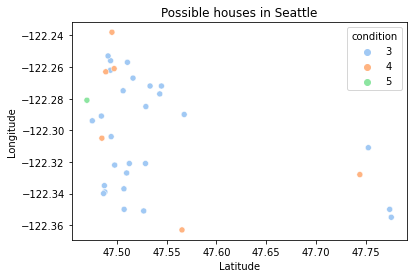

In [45]:
# plot the results
sns_plot = sns.scatterplot(data=df_results, y='long', x='lat', hue='condition', palette= "pastel" )
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.title('Possible houses in Seattle')
plt.show
plt.savefig("Possible houses in Seattle.png")


Condition = Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility. 

# 2 Houses in high density areas are cheaper?
if sqft_living_15 is small --> densitiy is high

In [24]:
# go back to the full dataframe for further analysis
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,lat/long,month,year
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0.0,1955,98178,47.5112,-122.257,1340,5650,"47.5112, -122.257",10,2014
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,3,7,2170,400.0,1951,98125,47.7210,-122.319,1690,7639,"47.721, -122.319",12,2014
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,3,6,770,0.0,1933,98028,47.7379,-122.233,2720,8062,"47.7379, -122.233",2,2015
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,5,7,1050,910.0,1965,98136,47.5208,-122.393,1360,5000,"47.5208, -122.393",12,2014
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,3,8,1680,0.0,1987,98074,47.6168,-122.045,1800,7503,"47.6168, -122.045",2,2015


In [25]:
# proportion of sqft_living vs. sqft_lot
# the smaller the proportion is, the bigger the lots around the houses ares
df['prop_liv_lot'] = df['sqft_living']/df['sqft_lot']
df.prop_liv_lot

0        0.208850
1        0.354874
2        0.077000
3        0.392000
4        0.207921
           ...   
21592    1.352785
21593    0.397385
21594    0.755556
21595    0.670017
21596    0.947955
Name: prop_liv_lot, Length: 21597, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

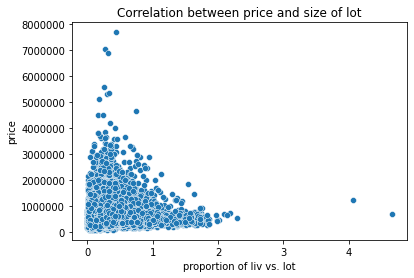

In [60]:
# plot price vs. proportion of sqft living/sqft lot
sns_plot = sns.scatterplot(data=df, y='price', x='prop_liv_lot')
plt.ylabel('price')
plt.xlabel('proportion of liv vs. lot')
plt.title('Correlation between price and size of lot')
plt.ticklabel_format(useOffset=False, style='plain', axis= 'y')
plt.show

In [27]:
# check the sqft of the neighboors 
df.sqft_living15.describe()

count    21597.000000
mean      1986.620318
std        685.230472
min        399.000000
25%       1490.000000
50%       1840.000000
75%       2360.000000
max       6210.000000
Name: sqft_living15, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

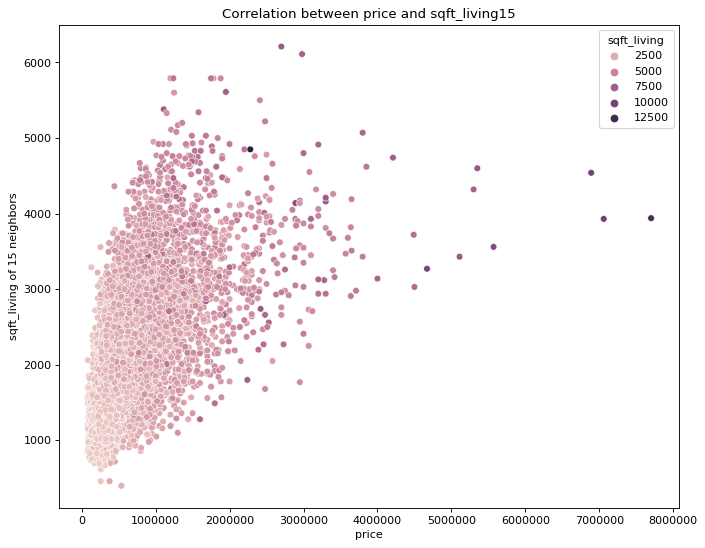

In [89]:
# plot Correlation between price and sqft_living15
plt.figure(figsize=(10,8), dpi=80)
sns_plot = sns.scatterplot(data=df, y='sqft_living15', x='price', hue='sqft_living')
plt.ylabel('sqft_living of 15 neighbors')
plt.xlabel('price')
plt.title('Correlation between price and sqft_living15')
plt.ticklabel_format(useOffset=False, style='plain', axis= 'x')
plt.savefig("Correlation between price and sqft_living15.png")
plt.show


In [29]:
# Prepare data for modeling
# Choose the predictor and add a constant term
X = df[['sqft_living15']]
y = df.price
# Our model needs an intercept so we add a column of 1s:
X = sms.add_constant(X)
display(X.head())
display(y.head())

,const,sqft_living15
0,1.0,1340
1,1.0,1690
2,1.0,2720
3,1.0,1360
4,1.0,1800


0    221900.0
1    538000.0
2    180000.0
3    604000.0
4    510000.0
Name: price, dtype: float64

In [30]:
# Create an OLS model
model = sms.OLS(y, X)
# use the data to calculate the intercept and slope
results = model.fit()
# return the output of the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                 1.125e+04
Date:                Fri, 01 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:18:49   Log-Likelihood:            -3.0286e+05
No. Observations:               21597   AIC:                         6.057e+05
Df Residuals:                   21595   BIC:                         6.057e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -8.303e+04   6216.659    -13.356      0.000   -9.52e+04   -7.08e+04
sqft_living15   313.7615      2.958    106.064      0.000     307.963     319.560
==============================================================================
Omnibus:                    20143.282   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1910578.895
Skew:                           4.207   Prob(JB):                         0.00
Kurtosis:                      48.303   Cond. No.                     6.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model explains around 34 % of the variance. 

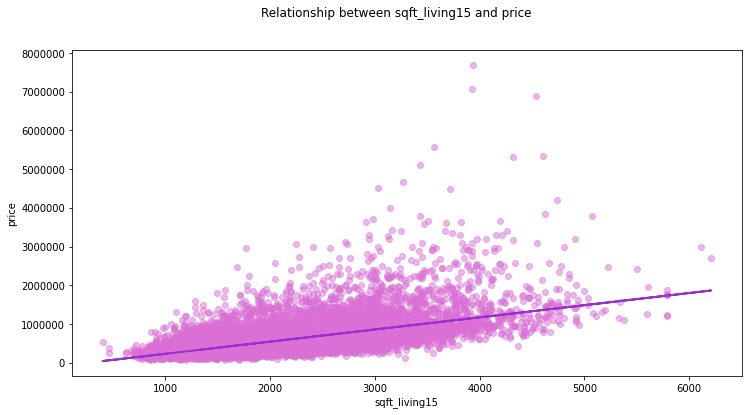

In [91]:
# Plotting the results of the model

intercept, slope = results.params

fig, ax = plt.subplots(figsize=(12, 6))
x = df.sqft_living15
# add data points
ax.scatter(x, y, alpha=0.5, color='orchid')
fig.suptitle('Relationship between sqft_living15 and price')
# plotting regression line
ax.plot(x, x*slope +intercept, '-', color='darkorchid', linewidth=2);
plt.ticklabel_format(useOffset=False, style='plain', axis= 'y')
ax.set_ylabel("price");
ax.set_xlabel("sqft_living15");

In [33]:
# expand the regression model
# price explained by sqft_living15 and sqft_living
smf.ols(formula='price ~ sqft_living15 + sqft_living', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                 1.078e+04
Date:                Fri, 01 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:18:50   Log-Likelihood:            -2.9991e+05
No. Observations:               21597   AIC:                         5.998e+05
Df Residuals:                   21594   BIC:                         5.999e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -9.926e+04   5427.190    -18.290      0.000    -1.1e+05   -8.86e+04
sqft_living15    68.0527      3.946     17.248      0.000      60.319      75.786
sqft_living     242.4444      2.945     82.329      0.000     236.672     248.216
==============================================================================
Omnibus:                    15568.864   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           682653.257
Skew:                           2.983   Prob(JB):                         0.00
Kurtosis:                      29.889   Cond. No.                     9.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Adding another variable improves the model, now around 50 % of the variance is explained.

In [70]:
# expand the regression model
# price explained by sqft_living15 and sqft_living and prop_liv_lot
smf.ols(formula='price ~ sqft_living15 + sqft_living + prop_liv_lot', data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     7386.
Date:                Fri, 01 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:05:50   Log-Likelihood:            -2.9977e+05
No. Observations:               21597   AIC:                         5.995e+05
Df Residuals:                   21593   BIC:                         5.996e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.398e+05   5873.682    -23.799      0.000   -1.51e+05   -1.28e+05
sqft_living15    78.6434      3.966     19.831      0.000      70.870      86.416
sqft_living     233.8705      2.966     78.851      0.000     228.057     239.684
prop_liv_lot   1.153e+05   6640.711     17.359      0.000    1.02e+05    1.28e+05
==============================================================================
Omnibus:                    16022.737   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           772064.089
Skew:                           3.087   Prob(JB):                         0.00
Kurtosis:                      31.633   Cond. No.                     1.30e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Further variables do not really improve the model.

In [76]:
# Print correlation of variables and look for further relationships
df[['sqft_living', 'sqft_living15', 'bedrooms', 'prop_liv_lot', 'condition', 'month', 'grade']].corr()

,sqft_living,sqft_living15,bedrooms,prop_liv_lot,condition,month,grade
sqft_living,1.000000,0.756402,0.578212,0.076988,-0.059445,0.012112,0.762779
sqft_living15,0.756402,1.000000,0.393406,-0.042097,-0.093072,0.002513,0.713867
bedrooms,0.578212,0.393406,1.000000,0.026798,0.026496,-0.001046,0.356563
prop_liv_lot,0.076988,-0.042097,0.026798,1.000000,-0.156501,0.010288,0.191398
condition,-0.059445,-0.093072,0.026496,-0.156501,1.000000,0.022388,-0.146896
month,0.012112,0.002513,-0.001046,0.010288,0.022388,1.000000,0.008989
grade,0.762779,0.713867,0.356563,0.191398,-0.146896,0.008989,1.000000


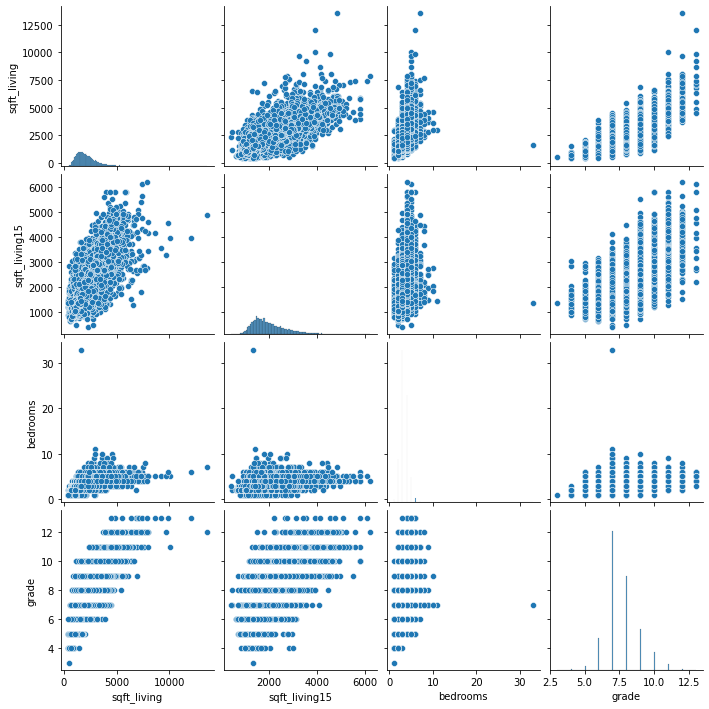

In [77]:
# plot the correlations
X3 = df[['sqft_living', 'sqft_living15', 'bedrooms', 'grade']]
sns.pairplot(X3)

In [79]:
# Define and fit model with multiple variables
X3 = sm.add_constant(X3)
y3 = df.price

model3 = sm.OLS(y3, X3)
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     6402.
Date:                Fri, 01 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:18:40   Log-Likelihood:            -2.9895e+05
No. Observations:               21597   AIC:                         5.979e+05
Df Residuals:                   21592   BIC:                         5.979e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.687e+05    1.5e+04    -31.335      0.000   -4.98e+05   -4.39e+05
sqft_living     210.8526      3.655     57.684      0.000     203.688     218.017
sqft_living15    12.8234      3.989      3.214      0.001       5.004      20.643
bedrooms      -4.274e+04   2267.911    -18.847      0.000   -4.72e+04   -3.83e+04
grade          8.998e+04   2379.630     37.813      0.000    8.53e+04    9.46e+04
==============================================================================
Omnibus:                    16548.900   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           912023.446
Skew:                           3.201   Prob(JB):                         0.00
Kurtosis:                      34.185   Cond. No.                     2.75e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Again only a small improvement of the model.

In [96]:
# check for nice, high density areas (sqft_living15 smaller than the mean) in prefiltered dataframe
df_possible_areas = df_possible_houses = df.query('bedrooms >= 5 and sqft_living >= 1500 and price <= 300000 and sqft_living15 <= 1980')
df_possible_areas

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,...,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,lat/long,month,year,prop_liv_lot
148,2014-10-30,258000.0,5,2.00,2260,12500,1.0,4,8,1130,...,1960,98032,47.3887,-122.286,1360,18000,"47.3887, -122.286",10,2014,0.180800
160,2014-05-07,255000.0,5,2.25,2060,8632,1.0,3,7,1030,...,1962,98146,47.4877,-122.335,1010,11680,"47.4877, -122.335",5,2014,0.238647
311,2014-10-23,201000.0,5,1.75,1660,78408,1.5,3,6,1660,...,1915,98065,47.5290,-121.837,1660,78408,"47.529, -121.837",10,2014,0.021171
331,2015-04-16,279000.0,6,1.75,2240,11180,2.0,4,7,2240,...,1955,98198,47.4200,-122.323,1590,7955,"47.42, -122.323",4,2015,0.200358
918,2014-05-19,290000.0,5,1.50,2120,7700,1.5,5,7,2120,...,1962,98058,47.4599,-122.172,1730,7700,"47.4599, -122.172",5,2014,0.275325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19461,2015-03-17,278000.0,5,1.50,1820,8712,1.0,5,7,1090,...,1960,98032,47.3712,-122.289,1820,8712,"47.3712, -122.289",3,2015,0.208907
20536,2014-05-19,298450.0,5,3.00,2100,9752,1.0,3,8,1200,...,2007,98003,47.3341,-122.304,1270,10200,"47.3341, -122.304",5,2014,0.215340
20636,2014-05-22,300000.0,5,2.50,2760,6000,2.0,3,8,2760,...,2006,98108,47.5289,-122.321,1360,6000,"47.5289, -122.321",5,2014,0.460000
20743,2014-06-25,260000.0,5,2.50,2025,7760,2.0,3,7,2025,...,2007,98001,47.2671,-122.256,1664,9000,"47.2671, -122.256",6,2014,0.260954


In [100]:
# show amount of matches
df_possible_areas.shape

(104, 21)

In [101]:
# check if a house is situated in one of the zip codes of Seattle
df_check_zipcode = df_possible_areas['zipcode'].apply(lambda x:1 if x in zip_codes else 0)

# join the two dataframes
df_possible_areas_outside = pd.concat([df_possible_areas, df_check_zipcode], axis=1)

# filter for zipcode = 0, meaning is NOT located in Seattle and show results
df_results3 = df_possible_areas_outside.query('zipcode == 0')
df_results3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 148 to 20868
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           75 non-null     datetime64[ns]
 1   price          75 non-null     float64       
 2   bedrooms       75 non-null     int64         
 3   bathrooms      75 non-null     float64       
 4   sqft_living    75 non-null     int64         
 5   sqft_lot       75 non-null     int64         
 6   floors         75 non-null     float64       
 7   condition      75 non-null     int64         
 8   grade          75 non-null     int64         
 9   sqft_above     75 non-null     int64         
 10  sqft_basement  75 non-null     object        
 11  yr_built       75 non-null     int64         
 12  zipcode        75 non-null     int64         
 13  lat            75 non-null     float64       
 14  long           75 non-null     float64       
 15  sqft_living15  75 no

22 houses match the criterias outside of Seattle City Center

<function matplotlib.pyplot.show(close=None, block=None)>

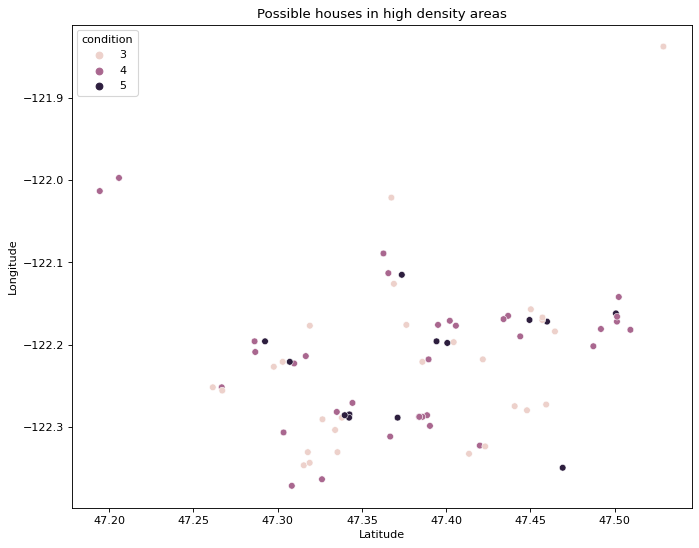

In [104]:
# plot the results
plt.figure(figsize=(10,8), dpi=80)
sns_plot = sns.scatterplot(data=df_results3, y='long', x='lat', hue='condition')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.title('Possible houses in high density areas')
plt.savefig("Possible houses in high density areas")
plt.show

In [88]:
# show coordinates of results
df_results3['lat/long']

148      47.3887, -122.286
1127     47.5014, -122.172
1158     47.3737, -122.115
1500       47.444, -122.19
1809     47.4407, -122.275
2264     47.4232, -122.324
2445     47.5025, -122.142
3594     47.4503, -122.157
3768     47.4218, -122.218
5572     47.3839, -122.288
7111     47.4919, -122.181
12114    47.3398, -122.286
13442    47.4874, -122.202
13530     47.4692, -122.35
13845    47.3266, -122.291
14875    47.3628, -122.089
15065    47.3098, -122.223
15760    47.3072, -122.221
16425    47.4007, -122.198
16789     47.303, -122.221
19050    47.2977, -122.227
20536    47.3341, -122.304
Name: lat/long, dtype: object